In [1]:
# predict house prices
# regression: predicting a continuous value instead of a discrete label

In [2]:
from keras.datasets import boston_housing


(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [3]:
# it would be problematic to feed into a neural network values
# that all take wildly different ranges.
# A widespread best practice to deal with such data is to do feature-wise normalization.

(404, 13) (102, 13)


In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [5]:
from keras import models
from keras import layers


def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [9]:
# k-fold validation
# spliting the available data into K partitions,
# instantiating K identical models,
# and training each one on K - 1 partitions
# while evaluating on the remaining partition.

array([[-0.40342651,  2.99178419, -1.33391162, -0.25683275, -1.21518188,
         1.89434613, -1.91036058,  1.24758524, -0.85646254, -0.34843254,
        -1.71818909,  0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , -0.25683275,  0.62864202,
        -1.82968811,  1.11048828, -1.18743907,  1.67588577,  1.5652875 ,
         0.78447637,  0.22061726, -1.30850006]])

In [13]:
import numpy as np


k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)

    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
         train_data[(i + 1) * num_val_samples :]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
         train_targets[(i + 1) * num_val_samples :]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    
    all_scores.append(val_mae)

processing fold # 0


2022-07-20 15:42:20.290952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 15:42:20.295031: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


processing fold # 1
processing fold # 2
processing fold # 3


In [17]:
import numpy as np


num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)

    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
         train_data[(i + 1) * num_val_samples :]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
         train_targets[(i + 1) * num_val_samples :]],
        axis=0)
    
    model = build_model()
    history = model.fit(
        partial_train_data, partial_train_targets, 
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [19]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

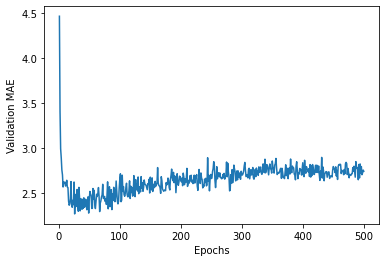

In [20]:
import matplotlib.pyplot as plt


plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

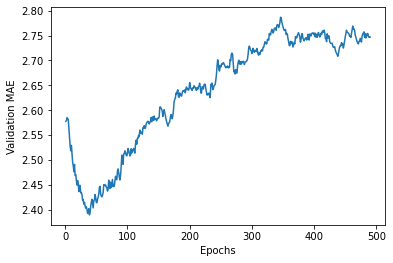

In [21]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
# once you're finished tuning other parameters of the model,
# you can train a final production model on all of the training data,
# with the best parameters,
# and then look at its performance on the test data

In [22]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 11ms/step - loss: 17.6278 - mae: 2.7834


In [23]:
print(test_mae_score)

2.783426284790039
